In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sys
from pathlib import Path

In [21]:
df_excel_v1 = pd.read_excel((Path("../calibration radiometer 6/data/Calibration_Housing_Rad6.xlsx")), sheet_name="All_Data")
df_excel_v1 = df_excel_v1.rename(columns={"Condition": "condition", "V_housing": "Vhousing", "T_housing": "T_thermocouple",})
df_excel_v2 = pd.read_excel((Path("./data/Calibration_T_housing_rad6_v2.xlsx")), sheet_name="All_Data")
df_excel_v2 = df_excel_v2.rename(columns={"Condition": "condition", "V_Housing": "Vhousing", "T_Housing_TC": "T_thermocouple",})

In [22]:
df_excel_v2['condition'] = df_excel_v2['condition'].replace({'open': 'V2 Open - heating', '25C': 'V2 25C', '50C': 'V2 50C'})

In [23]:
dff = pd.concat([df_excel_v1, df_excel_v2], ignore_index=True)

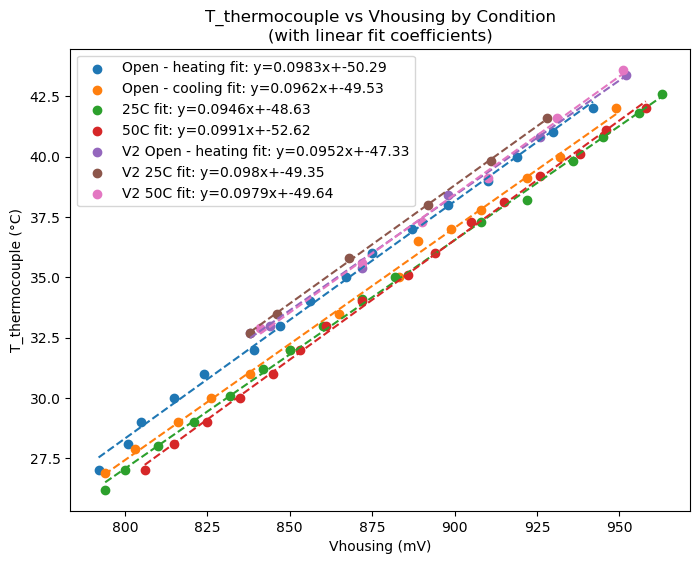

In [24]:
plt.figure(figsize=(8, 6))
colors = {'50°C': 'tab:blue', '25°C': 'tab:orange', 'OPEN': 'tab:green'}
unique_conditions = dff['condition'].unique()

for cond in unique_conditions:
    mask = dff['condition'] == cond
    x = dff.loc[mask, 'Vhousing']
    y = dff.loc[mask, 'T_thermocouple']
    
    # Linear regression for this condition
    if len(x) > 1:
        model = LinearRegression()
        model.fit(x.values.reshape(-1, 1), y.values)
        slope = model.coef_[0]
        intercept = model.intercept_
        plt.scatter(x, y, label=f"{cond} fit: y={slope:.3g}x+{intercept:.2f}", color=colors.get(cond, None))
        plt.plot(x, model.predict(x.values.reshape(-1, 1)), color=colors.get(cond, None), linestyle='--',
                 label=None)

plt.xlabel('Vhousing (mV)')
plt.ylabel('T_thermocouple (°C)')
plt.legend(loc='upper left')
plt.title('T_thermocouple vs Vhousing by Condition\n(with linear fit coefficients)')
plt.show()

In [34]:
# I will use a mean for HousingSlope and HousingOffset
HousingSlope = 0.098
HousingOffset = -49.2

def derive_t_housing_from_v_housing(v_housing):
    """
    Derive T_housing from V_housing using the OPEN condition linear regression.
    """
    return HousingSlope * v_housing + HousingOffset

In [28]:
X_1 = pd.read_csv(Path("../calibration radiometer 6/data/all_X.csv"))
X_1 = X_1[X_1['condition'].str.contains("heating")]
X_1['condition'] = X_1['condition'].replace({ '25C-heating': '25C', '50C-heating': '50C'})
X_1["V_rad"] = X_1["V_rad_short"]

X_2 = pd.read_csv(Path("./data/all_X.csv"))
X_2['condition'] = X_2['condition'].replace({'25C': 'V2 25C', '50C': 'V2 50C'})
X_2["V_rad"] = X_2["V_rad_tot"]

all_X = pd.concat([X_1, X_2], ignore_index=True)
all_X.condition.unique()

array(['25C', '50C', 'V2 25C', 'V2 50C'], dtype=object)

In [30]:
all_X.columns

Index(['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike',
       'time_index', 'condition', 'V_rad'],
      dtype='object')

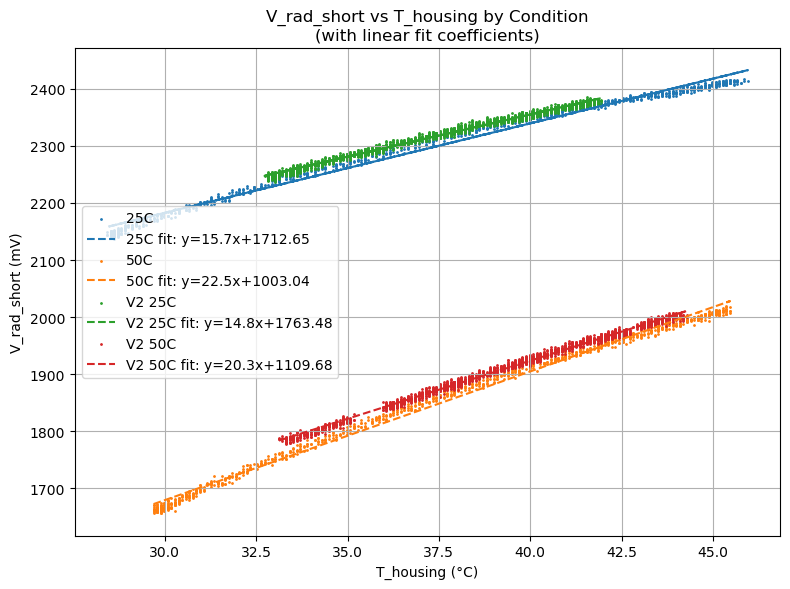

In [35]:
plt.figure(figsize=(8, 6))
for cond in all_X['condition'].unique():
    if cond == 'open':
        continue
    subset = all_X[all_X['condition'] == cond]
    # Calculate T_housing using the calibration function
    T_housing = derive_t_housing_from_v_housing(subset['V_housing'])
    # Plot V_rad_tot vs T_housing with smaller dots (no -2000 subtraction)
    plt.scatter(T_housing, subset['V_rad_short'], label=cond, color=colors.get(cond, None), s=1)
    # Linear regression for this condition
    x_curve = T_housing.values.reshape(-1, 1)
    y_curve = subset['V_rad_short'].values
    if len(x_curve) > 1:
        model_curve = LinearRegression()
        model_curve.fit(x_curve, y_curve)
        slope_curve = model_curve.coef_[0]
        intercept_curve = model_curve.intercept_
        plt.plot(T_housing, model_curve.predict(x_curve), color=colors.get(cond, None), linestyle='--',
                 label=f"{cond} fit: y={slope_curve:.3g}x+{intercept_curve:.2f}")
plt.xlabel('T_housing (°C)')
plt.ylabel('V_rad_short (mV)')
plt.title('V_rad_short vs T_housing by Condition\n(with linear fit coefficients)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

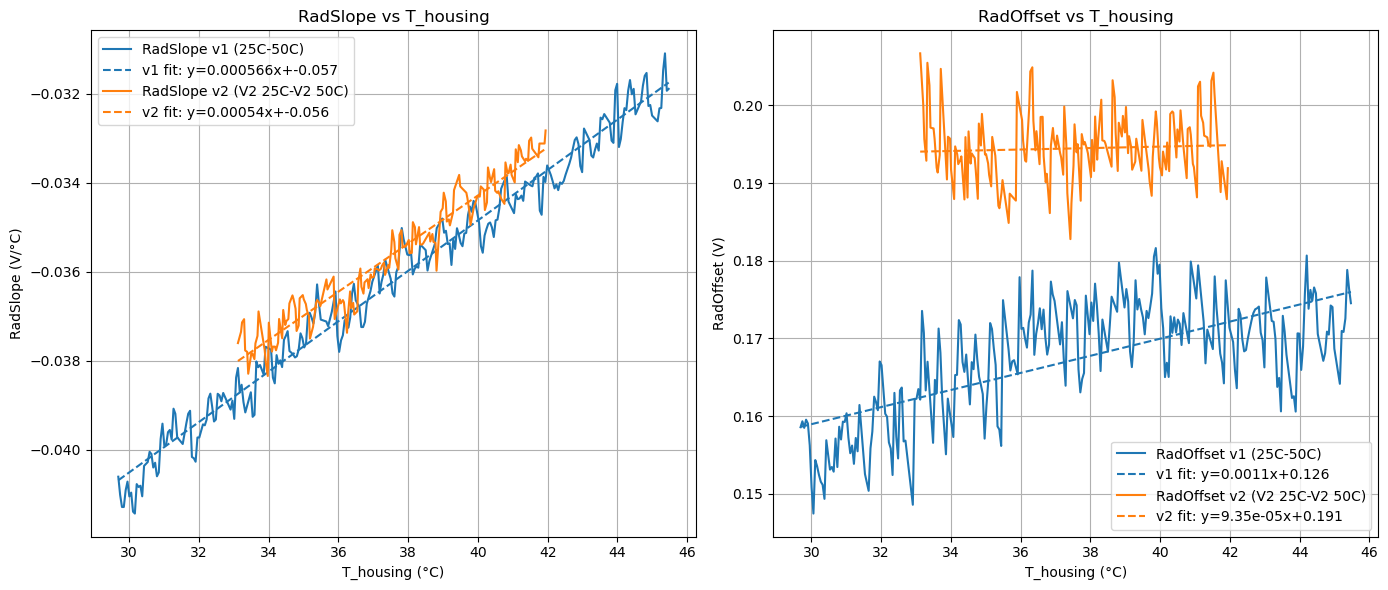

In [36]:
# Generate cond_25 and cond_50 DataFrames for both v1 and v2
cond_25_v1 = all_X[all_X['condition'] == '25C']
cond_50_v1 = all_X[all_X['condition'] == '50C']
cond_25_v2 = all_X[all_X['condition'] == 'V2 25C']
cond_50_v2 = all_X[all_X['condition'] == 'V2 50C']

# Calculate shared T_housing range for each pair
T_25_v1 = derive_t_housing_from_v_housing(cond_25_v1['V_housing'])
T_50_v1 = derive_t_housing_from_v_housing(cond_50_v1['V_housing'])
T_25_v2 = derive_t_housing_from_v_housing(cond_25_v2['V_housing'])
T_50_v2 = derive_t_housing_from_v_housing(cond_50_v2['V_housing'])

T_min_v1 = max(T_25_v1.min(), T_50_v1.min())
T_max_v1 = min(T_25_v1.max(), T_50_v1.max())
T_shared_v1 = np.linspace(T_min_v1, T_max_v1, 300)

T_min_v2 = max(T_25_v2.min(), T_50_v2.min())
T_max_v2 = min(T_25_v2.max(), T_50_v2.max())
T_shared_v2 = np.linspace(T_min_v2, T_max_v2, 300)

# Interpolate V_rad_short for both conditions at shared T_housing
V_25_interp_v1 = np.interp(T_shared_v1, T_25_v1, cond_25_v1['V_rad_short'].values)
V_50_interp_v1 = np.interp(T_shared_v1, T_50_v1, cond_50_v1['V_rad_short'].values)
V_25_interp_v2 = np.interp(T_shared_v2, T_25_v2, cond_25_v2['V_rad_short'].values)
V_50_interp_v2 = np.interp(T_shared_v2, T_50_v2, cond_50_v2['V_rad_short'].values)

# Calculate RadSlope and RadOffset for each shared temperature
RadSlope_v1 = (2 * (V_50_interp_v1 - V_25_interp_v1) / (50 - 25)) * 1e-3  # V/°C
RadOffset_v1 = (T_shared_v1 - 25) * RadSlope_v1 + 2 * V_25_interp_v1 / 1000 - 4  # V

RadSlope_v2 = (2 * (V_50_interp_v2 - V_25_interp_v2) / (50 - 25)) * 1e-3  # V/°C
RadOffset_v2 = (T_shared_v2 - 25) * RadSlope_v2 + 2 * V_25_interp_v2 / 1000 - 4  # V

# Linear regression for RadSlope and RadOffset vs T_housing
model_rs_v1 = LinearRegression().fit(T_shared_v1.reshape(-1, 1), RadSlope_v1)
model_ro_v1 = LinearRegression().fit(T_shared_v1.reshape(-1, 1), RadOffset_v1)
model_rs_v2 = LinearRegression().fit(T_shared_v2.reshape(-1, 1), RadSlope_v2)
model_ro_v2 = LinearRegression().fit(T_shared_v2.reshape(-1, 1), RadOffset_v2)

# Plot: RadSlope and RadOffset for both v1 and v2
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RadSlope plot
axes[0].plot(T_shared_v1, RadSlope_v1, color='tab:blue', label='RadSlope v1 (25C-50C)')
axes[0].plot(T_shared_v1, model_rs_v1.predict(T_shared_v1.reshape(-1, 1)), color='tab:blue', linestyle='--',
             label=f'v1 fit: y={model_rs_v1.coef_[0]:.3g}x+{model_rs_v1.intercept_:.3f}')
axes[0].plot(T_shared_v2, RadSlope_v2, color='tab:orange', label='RadSlope v2 (V2 25C-V2 50C)')
axes[0].plot(T_shared_v2, model_rs_v2.predict(T_shared_v2.reshape(-1, 1)), color='tab:orange', linestyle='--',
             label=f'v2 fit: y={model_rs_v2.coef_[0]:.3g}x+{model_rs_v2.intercept_:.3f}')
axes[0].set_xlabel('T_housing (°C)')
axes[0].set_ylabel('RadSlope (V/°C)')
axes[0].set_title('RadSlope vs T_housing')
axes[0].legend()
axes[0].grid(True)

# RadOffset plot
axes[1].plot(T_shared_v1, RadOffset_v1, color='tab:blue', label='RadOffset v1 (25C-50C)')
axes[1].plot(T_shared_v1, model_ro_v1.predict(T_shared_v1.reshape(-1, 1)), color='tab:blue', linestyle='--',
             label=f'v1 fit: y={model_ro_v1.coef_[0]:.3g}x+{model_ro_v1.intercept_:.3f}')
axes[1].plot(T_shared_v2, RadOffset_v2, color='tab:orange', label='RadOffset v2 (V2 25C-V2 50C)')
axes[1].plot(T_shared_v2, model_ro_v2.predict(T_shared_v2.reshape(-1, 1)), color='tab:orange', linestyle='--',
             label=f'v2 fit: y={model_ro_v2.coef_[0]:.3g}x+{model_ro_v2.intercept_:.3f}')
axes[1].set_xlabel('T_housing (°C)')
axes[1].set_ylabel('RadOffset (V)')
axes[1].set_title('RadOffset vs T_housing')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()